# Cours Langchain

**LangChain** est un framework conçu pour faciliter la création d'applications basées sur des modèles de langage, comme les chatbots, les assistants virtuels (agents) ou les outils RAG (Retrieval Augmented Generation).

Son utilité principale est donc de simplifier le développement d'applications qui nécessitent l'intégration et la gestion de plusieurs étapes dans le traitement du langage naturel.

## Principe des chaines

LangChain permet de composer des **chaînes de composants**, comme les `prompts`, les `LLM`, et les `parsers`, afin de traiter efficacement les entrées, générer des réponses et extraire des informations.

<div>
<img src="media/Chaine_Langchain.png" width="500"/>
</div>


Dans une chaîne, chaque étape est un objet `Runnable` (plus de détails plus loin).

Chaque étape est exécutée dans l'ordre dans lequel elles sont ajoutées à la chaîne, et **la sortie de l'étape précédente est passée en entrée de l'étape suivante**.

## Les composants

<div>
<img src="media/Composants_Langchain.png" width="500"/>
</div>

Tous ces composants sont des [Runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/). Un Runnable est un objet qui peut être appelé (avec Invoke, Batch ou Stream) pour exécuter une tâche. Ces runnables peuvent être enchaînés pour créer des chaines de traitement.

### Exemple de chaine de composants

Voici un exemple de chaine basique, écrit avec le LangChain Expression Language (LCEL) :

```python

from langchain_core.output_parsers.string import StringOutputParser

chain = prompt | model | StringOutputParser()

```

--> Voyons chacun de ces éléments un à un

### Prompt

*[Documentation](https://python.langchain.com/docs/concepts/#prompt-templates)*

Bien souvent le premier élément d'une chaîne. 

On va souvent créer un template de prompt puis utiliser [ChatPromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html) pour créer un prompt avec des instructions et des variables.

In [1]:
from langchain.prompts import ChatPromptTemplate

template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

prompt_template = ChatPromptTemplate.from_template(template_string)
prompt_template

ChatPromptTemplate(input_variables=['style', 'text'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['style', 'text'], input_types={}, partial_variables={}, template='Translate the text that is delimited by triple backticks into a style that is {style}. text: ```{text}```\n'), additional_kwargs={})])

Puis lors de l'invocation, on va lui donner un dictionnaire avec les `input_variables`, et il va les remplacer dans le template.

In [3]:
prompt_value = prompt_template.invoke(
    {
        "style": "American English in a calm and respectful tone",
        "text": """
Arrr, I be fuming that me blender lid flew off and splattered me kitchen walls \
with smoothie! And to make matters worse, the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help right now, matey!
"""
    }
)
prompt_value

ChatPromptValue(messages=[HumanMessage(content="Translate the text that is delimited by triple backticks into a style that is American English in a calm and respectful tone. text: ```\nArrr, I be fuming that me blender lid flew off and splattered me kitchen walls with smoothie! And to make matters worse, the warranty don't cover the cost of cleaning up me kitchen. I need yer help right now, matey!\n```\n", additional_kwargs={}, response_metadata={})])

### LLMs & Chat Models

On différencie `LLMs` classiques et les `Chat Models` par le fait que le Chat Model utilise une séquence de messages en input et renvoie des ChatMessage en output. UN LLM classique renvoie juste une string.

La plupart du temps on va utiliser des `Chat Models`

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0.1)

model

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000001DD67B69A90>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000001DD67B6B6E0>, root_client=<openai.OpenAI object at 0x000001DD67B0A7E0>, root_async_client=<openai.AsyncOpenAI object at 0x000001DD67B69AC0>, temperature=0.1, model_kwargs={}, openai_api_key=SecretStr('**********'))

### Parsers

*[Documentation](https://python.langchain.com/docs/how_to/#output-parsers)*

Les parsers ou output parsers sont utilisés pour transformer les outputs de LLM en format plus adapté. Utilisez les parsers pour récuperer des données en format plus structuré (json, str...)

In [17]:
# Exemple simple :
import json

response = model.invoke("give me a json with 5 fruits")
response

AIMessage(content='{\n  "fruits": [\n    {\n      "name": "apple",\n      "color": "red",\n      "taste": "sweet"\n    },\n    {\n      "name": "banana",\n      "color": "yellow",\n      "taste": "creamy"\n    },\n    {\n      "name": "orange",\n      "color": "orange",\n      "taste": "citrusy"\n    },\n    {\n      "name": "strawberry",\n      "color": "red",\n      "taste": "juicy"\n    },\n    {\n      "name": "kiwi",\n      "color": "green",\n      "taste": "tangy"\n    }\n  ]\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 15, 'total_tokens': 164, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1741e867-61ca-461b-a6b8-808920ab8c8e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 149, 'total_tokens': 164})

Ici on a une réponse de type `AIMessage`, et le contenu de la réponse est une string de json, qui n'aura même pas forcément toujours le même format, les mêmes clés, ou les mêmes valeurs. Mais imaginons qu'on veule récupérer le résultat dans un dictionnaire python avec un format spécifique pour pouvoir récupérer les informations ensuite.

On peut alors utiliser `StructuredOutputParser`

Note : Il y a plusieurs façons de forcer le format JSON en output, mais la façon la plus propre est en utilisant `Pydantic`.

In [22]:
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field

class Fruit(BaseModel):
    name: str = Field(description="name of the fruit")
    color: str = Field(description="color of the fruit")
    taste: str = Field(description="taste of the fruit, can be one of sweet, sour, bitter, tangy, or citrusy")


parser = JsonOutputParser(pydantic_object=Fruit)

fruit_query = "Give me a list of 5 fruits"

# ici le parser va automatiquement créer des instructions à donner au modèle pour qu'il formate le résultat correctement
prompt = ChatPromptTemplate.from_template(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    partial_variables={"format_instructions": parser.get_format_instructions()} 
)

chain = prompt | model | parser

chain.invoke({"query": fruit_query})

{'fruits': [{'name': 'Apple', 'color': 'Red', 'taste': 'Sweet'},
  {'name': 'Banana', 'color': 'Yellow', 'taste': 'Sweet'},
  {'name': 'Orange', 'color': 'Orange', 'taste': 'Citrusy'},
  {'name': 'Grapes', 'color': 'Purple', 'taste': 'Sweet'},
  {'name': 'Lemon', 'color': 'Yellow', 'taste': 'Sour'}]}

Si on regarde ce que `parser.get_format_instructions()` a fait : 

In [23]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"name": {"description": "name of the fruit", "title": "Name", "type": "string"}, "color": {"description": "color of the fruit", "title": "Color", "type": "string"}, "taste": {"description": "taste of the fruit, can be one of sweet, sour, bitter, tangy, or citrusy", "title": "Taste", "type": "string"}}, "required": ["name", "color", "taste"]}\n```'

### Retrievers

*[documentation](https://python.langchain.com/docs/how_to/#retrievers)*

Les `Retrievers` sont chargés de prendre une requête et de renvoyer des documents pertinents.

Ils sont principalement utilisés dans le cas de [Retrieval Augmented Generation](https://python.langchain.com/docs/tutorials/rag/) (RAG), où ils permettent de récupérer des documents pertinents à fournir à un LLM pour répondre à une question.

### Tools

*[Documentation](https://python.langchain.com/docs/how_to/#tools)*

Les `Tools` sont des utilitaires conçus pour être appelés par un modèle : leurs inputs sont conçues pour être générées par les modèles et leurs outputs sont conçues pour être renvoyées aux modèles. Les `Tools` sont nécessaires chaque fois que vous souhaitez qu'un modèle contrôle des parties de votre code ou fasse appel à des API externes.

La suite sur les Agents et tools plus loin.

## Retrieval Augmented Generation (RAG)

[*Documentation*](https://python.langchain.com/docs/tutorials/rag/)

RAG est une technique permettant d'enrichir les connaissances d'un LLM avec des données supplémentaires.

Une application RAG typique comporte deux éléments principaux :
- **Indexing** : un pipeline permettant d'ingérer des données à partir d'une source et de les indexer, ce qui se fait généralement hors ligne.
- **Retrieval & Generation** : la chaîne RAG proprement dite, qui prend la requête de l'utilisateur au moment de l'exécution et récupère (retrieve) les données pertinentes de l'index, puis les transmet au modèle.

La séquence complète la plus courante, des données brutes à la réponse, ressemble à ce qui suit :

### Indexing

1. **Load** : Nous devons d'abord charger nos données. Cette opération s'effectue à l'aide de [Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/). 
2. **Split** : Les [séparateurs de texte](https://python.langchain.com/docs/how_to/#text-splitters) divisent les `Documents` volumineux en 'chunks' plus petits. Cela est utile à la fois pour indexer les données et pour les transmettre à un modèle, car les gros morceaux sont plus difficiles à rechercher et ne tiennent parfois pas dans la fenêtre contextuelle d'un modèle.

    [Visualiser les différentes techniques de chunking](https://huggingface.co/spaces/m-ric/chunk_visualizer).
3. **Store** : Nous avons besoin d'un endroit pour stocker et indexer nos divisions, afin de pouvoir les rechercher ultérieurement. Cela se fait souvent à l'aide d'un [VectorStore](https://python.langchain.com/docs/how_to/#vector-stores) et d'un modèle d'[Embeddings](https://python.langchain.com/docs/integrations/text_embedding/).

<div>
<img src="media/rag_indexing.png" width="700"/>
</div>

Exemple :

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

# récupérer les documents à partir d'un loader (ici on récupère du texte en ligne)
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

##  Séparer en chunks de 500 tokens chacun
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)

embeddings = OpenAIEmbeddings()

# Embedding de chacun de nos splits et Stockage dans une variable
vectorstore = FAISS.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())



# LLM
llm = ChatOpenAI()

**Récapitulatif :**

[Source](https://huggingface.co/learn/cookbook/en/rag_evaluation)

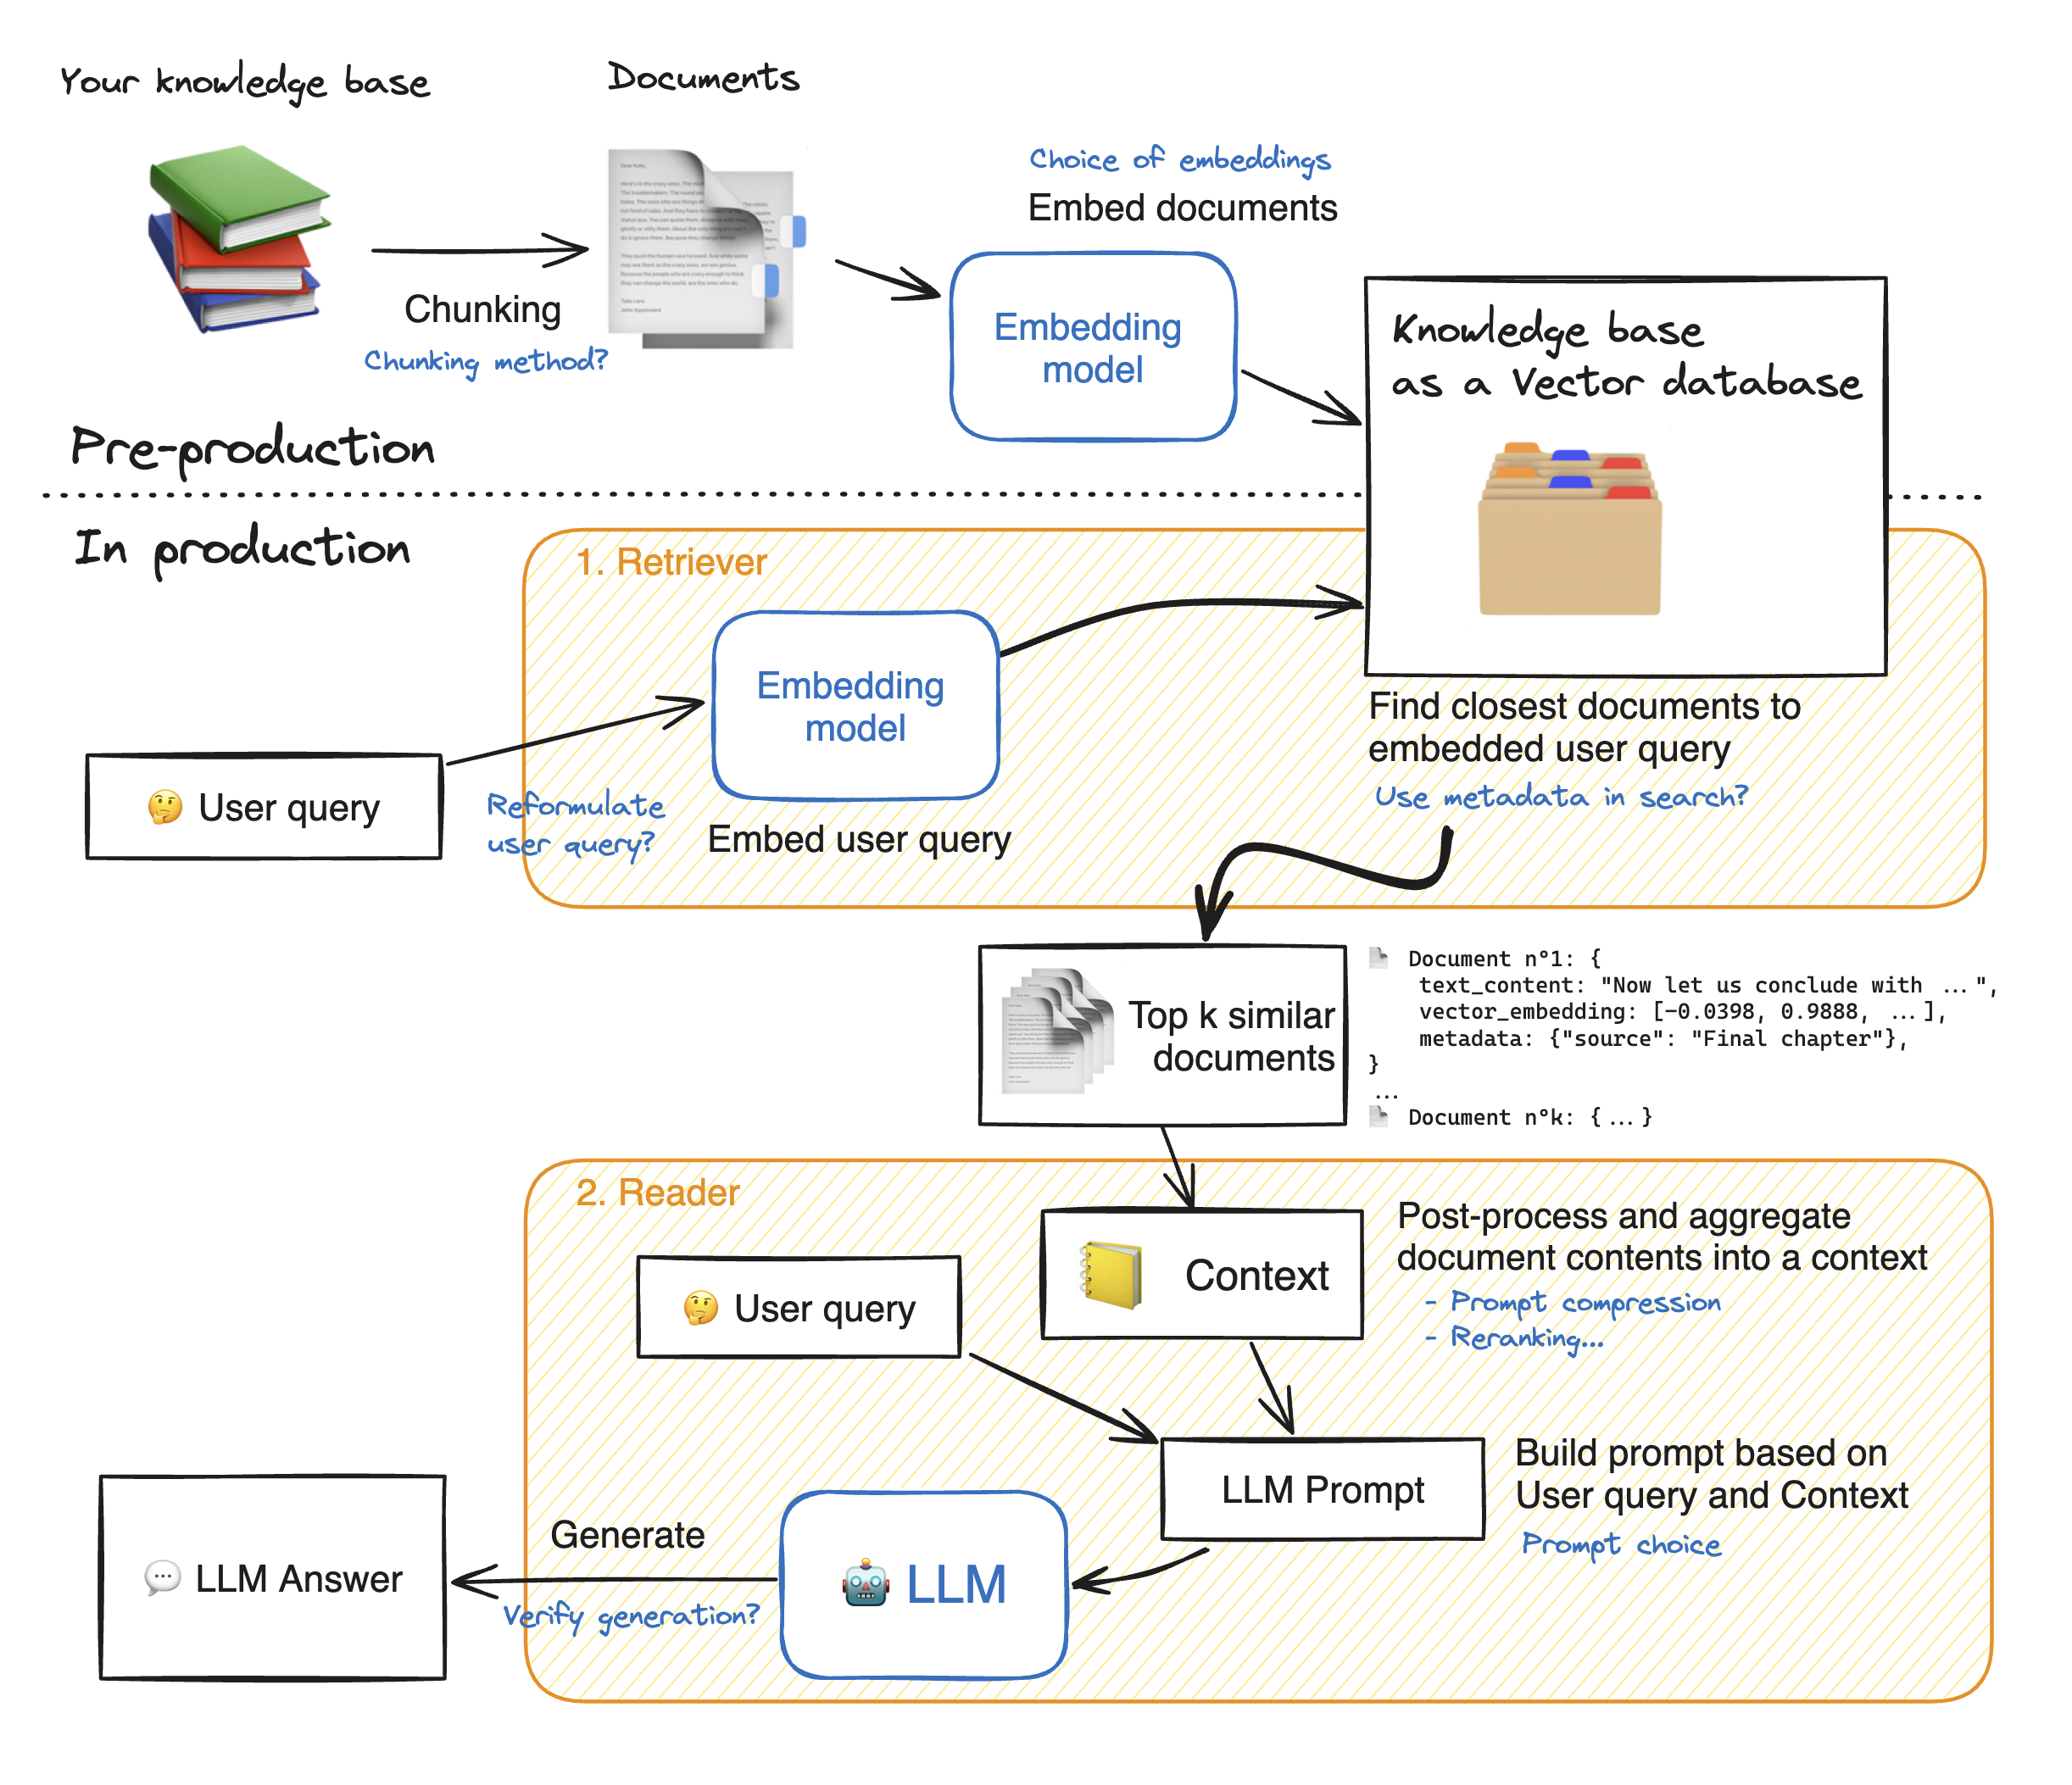

## Agents & Tools

## Chat History

## Evaluation